# Проект для "Викишоп" с BERT

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

__Задача__
* Обучить модель классифицировать комментарии на позитивные и негативные. 
* Метрики качества F1 должна быть не меньше 0.75

В вашем распоряжении набор данных с разметкой о токсичности правок.

## Загружаем необходимые библиотеки

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import re

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertTokenizer
from transformers import DataCollatorWithPadding

from datasets import load_dataset, get_dataset_split_names, Dataset

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
import spacy
!python -m spacy download en_core_web_sm

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Убедимся, что мы можем использовать видеокарту и подключим ее.

In [3]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print(f"Количество доступных видеокарт: {torch.cuda.device_count()}")
    print(f'Будем использовать: {torch.cuda.get_device_name(0)}')

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('Видеокарта не доступна. Используется процессор')
    device = torch.device("cpu")
    
torch.cuda.empty_cache()

Количество доступных видеокарт: 1
Будем использовать: Tesla P100-PCIE-16GB


## Загрузим и проанализируем имеющиеся данные.

Файл содержит два столбца:

* `text` — текст комментария
* `toxic` — целевой признак

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


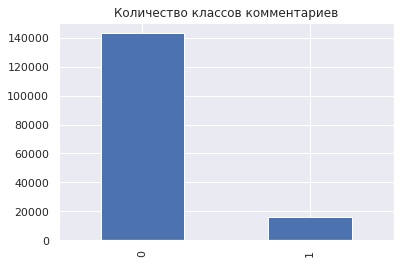

In [6]:
df['toxic'].value_counts().plot(kind='bar')
plt.title('Количество классов комментариев')
None

Комментарии содержат сильный дисбаланс классов. На каждый негативный комментарий приходится примерно 7 позитивных. Нужно будет учитывать это при обучении моделей.

## Подготовим текст для анализа

Уберем лишние пробелы, знаки препинания, приведем все символы в нижний регистр.

In [7]:
df['text'] = df['text'].apply(lambda words: re.sub("[^a-zA-Z]", " ", words))
df['text'] = df['text'].str.lower()
df['text_tokens'] = df['text'].apply(lambda token: " ".join(token.split()))

In [8]:
df.head()

,text,toxic,text_tokens
0,explanation why the edits made under my userna...,0,explanation why the edits made under my userna...
1,d aww he matches this background colour i m s...,0,d aww he matches this background colour i m se...
2,hey man i m really not trying to edit war it...,0,hey man i m really not trying to edit war it s...
3,more i can t make any real suggestions on im...,0,more i can t make any real suggestions on impr...
4,you sir are my hero any chance you remember...,0,you sir are my hero any chance you remember wh...


Посмотрим на распределение количества слов в комментариях.

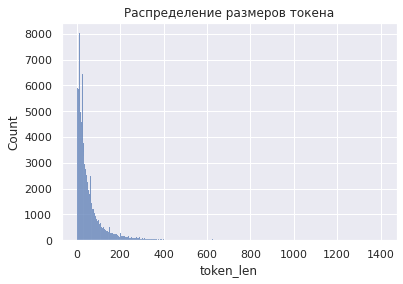

In [9]:
df['token_len'] = [len(words.split(' ')) for words in df['text_tokens']]

sns.histplot(df['token_len'])
plt.title('Распределение размеров токена')
None

In [10]:
df['token_len'].describe()

count    159292.000000
mean         68.072094
std         100.837220
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
Name: token_len, dtype: float64

В данных иногда встречаются комментарии длиннее 512 слов. Надо будет учесть это при работе с токенайзером.

## Разобьем выборку на тренировочную и тестовую.

Так как в нашем распоряжении большой датасет, мы можем отвести на тест 10% наблюдений. Такое разбиение позволит модели увидеть больше слов при обучении и лучше понять семантику комментариев.

In [11]:
train, test = train_test_split(df[['text_tokens', 'toxic']], test_size=0.1, random_state=42, shuffle=True)

In [12]:
for df in [train, test]:
  print(df.shape)

(143362, 2)
(15930, 2)


## Обучение моделей

### Модель-заглушка

Отметим все комментарии как токсичные

In [13]:
dummy = np.ones(test.shape[0])

print(f"f1 заглушки: { f1_score(test['toxic'], dummy) }")

f1 заглушки: 0.18420152741365553


## Попробуем логистическую регрессию с сочетанием TF-IDF

Для этого лемматизируем тексты и передадим их TF-IDF

In [14]:
def lemmatize_text(text):
  nlp = spacy.load("en_core_web_sm")
  lemm_tokens_list = []
  for doc in tqdm(nlp.pipe(text, disable=['parser', 'ner']), total=len(text)):
    lemmas = " ".join([token.lemma_ for token in doc])
    lemm_tokens_list.append(lemmas)
  return lemm_tokens_list

In [15]:
%%time
train_lemm_tokens = lemmatize_text(train['text_tokens'])
test_lemm_tokens = lemmatize_text(test['text_tokens'])

100%|██████████| 15930/15930 [01:01<00:00, 259.03it/s]

CPU times: user 9min 18s, sys: 4.43 s, total: 9min 22s
Wall time: 9min 25s


In [16]:
with open(r'train_lemm_tokens.txt', 'w') as f:
  f.write('\n'.join(train_lemm_tokens))
  f.close()

with open(r'test_lemm_tokens.txt', 'w') as f:
  f.write('\n'.join(test_lemm_tokens))
  f.close()

Убедимся, что лемматизация сработала.

In [18]:
display(train_lemm_tokens[:2])
display(test_lemm_tokens[:2])

['stop delete image without first consulting quadell you need to stop delete image without first consulting with the person who post they that be bad behavior on your part cease and desist if you think there s a problem first discuss it with the person involve don t take matter into your own hand and just take action do that show disrespect to other and make people angry ledastray',
 'controversial material of any kind that be unsourced or poorly source must be remove immediately especially if potentially libelous blp rule be apply it seem']

['sometime back I just happen to log on to www izoom in with a friend s reference and I be amazed to see the concept fresh idea entertainment have come up with so many deal all under one roof this website be very user friendly and easy to use and be fun to be on you have gossip game fact another exciting feature to add to it be face of the week every week new face be select and put up as izoom face it s great to have be select in four out of a group of million this new start up have already get many a deal in its kitty few of they be thefortune hotel the beach be my personal favorite izoom in have a usp of mobile coupon coupon be available even when a user can not access internet you just need to sms izoom support to and you get attend immediately all I can say be izoom in be a must visit website for everyone before they go out for shopping or dining or for out cheer',
 'the late edit be much well don t make this article state super at all']

Для того, чтобы логистическая регрессия сходилась, масштабируем данные, используем солвер saga и добавим количество итераций.

In [19]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_tf_idf = count_tf_idf.fit_transform(train_lemm_tokens)
test_tf_idf = count_tf_idf.transform(test_lemm_tokens)

In [20]:
print(train_tf_idf.shape, test_tf_idf.shape)

(143362, 142525) (15930, 142525)


In [21]:
scaler = preprocessing.StandardScaler(with_mean=False)
train_tf_idf_scaled = scaler.fit_transform(train_tf_idf)
test_tf_idf_scaled = scaler.transform(test_tf_idf)

In [22]:
%%time
logreg = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

grid={"C":range(0,16,3),
      "solver":['saga', 'sag']}

logreg_cv=RandomizedSearchCV(logreg, grid, cv=3, scoring='f1', 
                             verbose=2, random_state=42)
logreg_cv.fit(train_tf_idf_scaled, train['toxic'])

print('==='*10)
print(logreg_cv.best_params_)
print('==='*10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=15, solver=saga; total time=  33.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=15, solver=saga; total time=  33.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=15, solver=saga; total time=  32.9s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=12, solver=sag; total time=  32.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=12, solver=sag; total time=  34.2s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=12, solver=sag; total time=  32.0s
[CV] END ...................................C=0, solver=saga; total time=   0.0s
[CV] END ...................................C=0, solver=saga; total time=   0.0s
[CV] END ...................................C=0, solver=saga; total time=   0.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=12, solver=saga; total time=  32.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=12, solver=saga; total time=  32.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..................................C=12, solver=saga; total time=  33.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ....................................C=6, solver=sag; total time=  33.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ....................................C=6, solver=sag; total time=  33.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ....................................C=6, solver=sag; total time=  34.5s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=3, solver=saga; total time=  32.7s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=3, solver=saga; total time=  33.3s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=3, solver=saga; total time=  32.9s
[CV] END ....................................C=0, solver=sag; total time=   0.0s
[CV] END ....................................C=0, solver=sag; total time=   0.0s
[CV] END ....................................C=0, solver=sag; total time=   0.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=15, solver=sag; total time=  31.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=15, solver=sag; total time=  31.8s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=15, solver=sag; total time=  31.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=6, solver=saga; total time=  32.6s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=6, solver=saga; total time=  33.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ...................................C=6, solver=saga; total time=  33.0s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ....................................C=9, solver=sag; total time=  32.4s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ....................................C=9, solver=sag; total time=  32.1s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1614, in fit
    for class_, warm_start_coef_ in zip(

[CV] END ....................................C=9, solver=sag; total time=  32.2s
{'solver': 'saga', 'C': 15}
CPU times: user 13min 56s, sys: 555 ms, total: 13min 56s
Wall time: 13min 59s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [23]:
%%time
logreg_best = LogisticRegression(**logreg_cv.best_params_)
logreg_best.fit(train_tf_idf, train['toxic'])
predictions = logreg_best.predict(test_tf_idf)
print(f"f1 логистической регрессии {f1_score(test['toxic'], predictions)}")

f1 логистической регрессии 0.7886262418636518
CPU times: user 6.91 s, sys: 1.02 ms, total: 6.91 s
Wall time: 6.91 s


Сочетание TF-IDF с логистической регрессией удовлетворяет требованию минимальной метрики качества. F1 мера составляет 0.788. Плюс данного подхода в том, что на обучение и предсказание модели уходит 8 секунд. Также для нее работы и не требуется подключения графического процессора.

## Попробуем модель BERT 

Работа с BERT занимает много времени. Для ускорения работы блокнота сделаем тренировочную подвыборку, в которой содержатся все плохие комментарии и 40000 хороших.

In [24]:
train['train_lemms'] = train_lemm_tokens
test['test_lemms'] = test_lemm_tokens

train_subset = train[['train_lemms', 'toxic']].query("toxic == 1").copy()
train_subset = train_subset.append(train[['train_lemms', 'toxic']].query("toxic == 0").sample(40000))
train_subset.columns = ['text', 'label']
train_subset

,text,label
49248,goodnightmush I have two word for you go fuck ...,1
58098,orane suck lot of penis with genital wart and ...,1
106093,get lose don t bother I again you miserable pi...,1
18366,awwww poor mark arsten doesn t have privilage ...,1
17025,you be the troll anti semite all anti semite s...,1
...,...,...
97040,forgive my disrespect towards you sit but be y...,0
15429,I ll bet if it s just up for a day or so and t...,0
154880,this need a speedy close or something like it ...,0
150412,have one article for both vancouver whitecap t...,0


In [25]:
test = test[['test_lemms', 'toxic']]
test.columns = ['text', 'label']
test

,text,label
31055,sometime back I just happen to log on to www i...,0
102929,the late edit be much well don t make this art...,0
67385,october utc I would think you d be able to get...,0
81167,thank for the tip on the currency translation ...,0
90182,I would argue that if content on the con in co...,0
...,...,...
158432,do anyone know if sora ltd be a nintendo secon...,0
328,who care if I be block on myspace or pulse mus...,0
86906,because you be a tweet cunt flap,1
96662,reference source you should take care to refer...,0


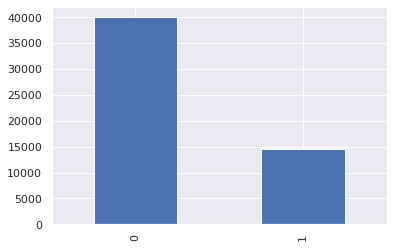

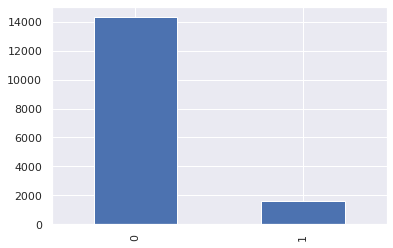

In [26]:
train_subset['label'].value_counts().plot(kind='bar')
plt.show()
test['label'].value_counts().plot(kind='bar')
plt.show()

Переведем таблицы в формат для работы с трансформерами

In [27]:
train_dataset = Dataset.from_pandas(train_subset, preserve_index=False)
test_dataset = Dataset.from_pandas(test, preserve_index=False)

In [28]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 54570
})

In [29]:
test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 15930
})

Подготовим текст к работе с BERT

In [30]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [31]:
def preprocess_function(sample):
    return tokenizer(sample["text"], truncation=True)

In [32]:
%%time

train_tokenized = train_dataset.map(preprocess_function, batched=True)
test_tokenized = test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/55 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

CPU times: user 24 s, sys: 129 ms, total: 24.2 s
Wall time: 14.1 s


In [33]:
# упакуем токены в матрицу одинакового размера
data_collacator = DataCollatorWithPadding(tokenizer=tokenizer)

Подготовим модель для решения бинарной классификации. 

In [34]:
%%time
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)
model.to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

CPU times: user 7.67 s, sys: 2.42 s, total: 10.1 s
Wall time: 14.8 s


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Определим аргументы и тренера

In [35]:
training_args = TrainingArguments(
    output_dir = "kaggle/working",
    per_device_train_batch_size = 16,
    learning_rate = 2e-5,
    num_train_epochs = 1,
    weight_decay = 0.01
)

In [36]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collacator,
    train_dataset = train_tokenized,
    tokenizer = tokenizer,
)

Запустим тренировку модели на графическом процессоре.

In [38]:
%%time
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 54570
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3411
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
500,0.234000
1000,0.174900
1500,0.174300
2000,0.147900
2500,0.158900
3000,0.143600


Saving model checkpoint to kaggle/working/checkpoint-500
Configuration saved in kaggle/working/checkpoint-500/config.json
Model weights saved in kaggle/working/checkpoint-500/pytorch_model.bin
tokenizer config file saved in kaggle/working/checkpoint-500/tokenizer_config.json
Special tokens file saved in kaggle/working/checkpoint-500/special_tokens_map.json
Saving model checkpoint to kaggle/working/checkpoint-1000
Configuration saved in kaggle/working/checkpoint-1000/config.json
Model weights saved in kaggle/working/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in kaggle/working/checkpoint-1000/tokenizer_config.json
Special tokens file saved in kaggle/working/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to kaggle/working/checkpoint-1500
Configuration saved in kaggle/working/checkpoint-1500/config.json
Model weights saved in kaggle/working/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in kaggle/working/checkpoint-1500/tokenizer_config.js

CPU times: user 14min 26s, sys: 9.01 s, total: 14min 35s
Wall time: 14min 50s


TrainOutput(global_step=3411, training_loss=0.1696165896202944, metrics={'train_runtime': 890.372, 'train_samples_per_second': 61.289, 'train_steps_per_second': 3.831, 'total_flos': 4294331751785640.0, 'train_loss': 0.1696165896202944, 'epoch': 1.0})

Сделаем предсказания

In [39]:
%%time
predictions = trainer.predict(test_tokenized)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 15930
  Batch size = 8


CPU times: user 1min 8s, sys: 585 ms, total: 1min 8s
Wall time: 1min 8s


In [40]:
predictions[0]

array([[ 3.384247 , -3.137483 ],
       [ 3.241423 , -2.993238 ],
       [ 3.1164355, -2.8335006],
       ...,
       [-2.8335311,  3.1950586],
       [ 3.3316774, -3.0639207],
       [ 2.0395527, -1.792161 ]], dtype=float32)

Достанем классы из предсказаний

In [41]:
# вернем индекс максимального значения в каждой строке
test_predictions = np.argmax(predictions[0], axis=1)

# убедимся, что все работает
print(predictions[0])
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

[[ 3.384247  -3.137483 ]
 [ 3.241423  -2.993238 ]
 [ 3.1164355 -2.8335006]
 ...
 [-2.8335311  3.1950586]
 [ 3.3316774 -3.0639207]
 [ 2.0395527 -1.792161 ]]
<class 'numpy.ndarray'>
15930

[0 0 0 ... 1 0 0]


In [42]:
print(f"f1 BERT {f1_score(test['label'], test_predictions)}")

f1 BERT 0.8028477546549836


Модель BERT справляется с классификацией токсичных комментариев. Но тратит на обучение 15 минут, а на предсказание 1 минуту. При этом метрика f1 составляет 0,824.

## Вывод

В ходе работы над проектом мы проанализировали работу двух моделей:

* Модель логистической регрессии в сочетании с векторным представлением теста в формате TF-IDF: f1 мера составляет 0,788. Также плюсом являются быстрые обучение и предсказания, а также низкие системные требования для ее работы.

* Модель BERT: f1 мера составляет 0,824. При этом для ее достижения необходимо задействовать времязатратные вычисления на графическом процессоре.

Обе модели выполняют условия поставленной задачи, и имеют свои преимущества и недостатки, описанные выше.